In [1]:
import os
os.chdir(os.environ['PROJECT_ROOT'])

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap
from lightgbm import LGBMRegressor
from pathlib import Path
from pandas.core.common import SettingWithCopyWarning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from mentorship.features.kaggle.storesales.etl import ETLTransformer
from mentorship.features.history import cut_history
from mentorship.features.tuning import boruta_features_tuning
from mentorship.ml.cv.split import DateTimeSeriesSplit
from mentorship.ml.cv.util import format_cv_test_scores
from mentorship.ml.models.kaggle.storesales.hyperparams.tuning import tune_hyperparams
from mentorship.ml.models.kaggle.storesales.boosting import LGBMPipeline
from mentorship.ml.models.kaggle.storesales.linear import LinearPipeline
from mentorship.ml.models.common import RecursiveTSEstimator
from mentorship.ml.models.kaggle.storesales.estimators import RecursiveTSEstimatorWithZeroCategories
from mentorship.ml.tools.kaggle.storesales.submission import make_submission_file
from mentorship.ml.tools.kaggle.storesales.curves import plot_learning_curver
from mentorship.ml.tools.timeit import timeit


%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
CV_METRICS = [
    'neg_mean_squared_log_error',
    'neg_root_mean_squared_error',
    'neg_mean_absolute_error',
    'r2'
]

In [4]:
DATA_ROOT = Path('data', 'kaggle', 'store-sales-time-series-forecasting')

In [5]:
train = pd.read_csv(DATA_ROOT / 'train.csv')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
N_STORES = train['store_nbr'].nunique()
N_FAMILIES = train['family'].nunique()
N_TIME_SERIES = N_STORES * N_FAMILIES

DAYS_IN_YEAR = 365
N_HORIZONS = 16

# 0.1 test (linear regression with best lags)

In [ ]:
# ETL stage for the train data

lags = [1, 2, 4, 6, 7, 14]

X = train.copy()
train_transformer = ETLTransformer(lags=lags, target_col='sales', use_final_metric=False)
X = train_transformer.transform(X)

y = X['sales'].copy()

X.head()

In [ ]:
# cross validation

splitter = DateTimeSeriesSplit()
base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                    drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                    target_col='sales', use_final_metric=False)

modelling_pipeline = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='family', target_col='sales')

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise')
print_cv_test_scores(scores)

In [8]:
# getting X_train and y_train for the final model training

X_train, y_train = cut_history(X=X, date_column='date', keep_interval=pd.Timedelta(days=DAYS_IN_YEAR), y=y)

In [8]:
# ETL stage for the test data

test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer()
test_data = test_transformer.transform(test_data)[0]
test_data.head()

,date,store_nbr,family,onpromotion,dcoilwtico
0,2017-08-16,1,automotive,0,46.8
1,2017-08-16,1,baby care,0,46.8
2,2017-08-16,1,beauty,2,46.8
3,2017-08-16,1,beverages,20,46.8
4,2017-08-16,1,books,0,46.8


In [ ]:
# fitting the final model and making submission file

modelling_pipeline.fit(X_train, y_train)
make_submission_file(test_data, modelling_pipeline, 'linreg_with_recursive_lags1.csv')

# 0.2 test (LGBMRegressor with default params, same features)

In [7]:
lags = [1, 2, 4, 6, 7, 14]

X = train.copy()
y = X['sales'].copy()

train_transformer = ETLTransformer(lags=lags, target_col='sales')
X = train_transformer.transform(X)
splitter = DateTimeSeriesSplit()

X.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,lag_1,lag_2,lag_4,lag_6,lag_7,lag_14
0,2013-01-01,1,automotive,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,baby care,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,beauty,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,beverages,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,books,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Here I have a question: how to pass 'categorical_feature' parameter to the PositiveRegressor(lgb.LGBMRegressor)?
# Inside 'fit' method, X matrix has np.ndarray type, so I can't pass the name of the feature to 'categorical_feature' parameter.
# That is why I have to pass indices of the columns I need to mark as 'categorical' (indices become clear only 
# after ColDrop stage)

params = {'categorical_feature': 'name: "store_nbr"'}
base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LGBMPipeline(drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                  target_col='sales', level=['store_nbr'], params=params)
modelling_pipeline = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='family', target_col='sales')

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise')
format_cv_test_scores(scores, metrics_to_plot=['root_mean_squared_log_error'])

root_mean_squared_log_error: 0.459 ± 0.022
root_mean_squared_error: 271.186 ± 34.090
mean_absolute_error: 72.590 ± 8.938
r2: 0.955 ± 0.011


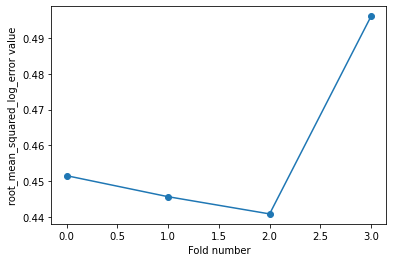

In [9]:
format_cv_test_scores(scores, metrics_to_plot=['root_mean_squared_log_error'])

In [9]:
X_train, y_train = cut_history(X=X, date_column='date', keep_interval=pd.Timedelta(days=DAYS_IN_YEAR), y=y)

In [10]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer()
test_data = test_transformer.transform(test_data)
test_data.head()

,date,store_nbr,family,onpromotion,dcoilwtico
0,2017-08-16,1,automotive,0,46.8
1,2017-08-16,1,baby care,0,46.8
2,2017-08-16,1,beauty,2,46.8
3,2017-08-16,1,beverages,20,46.8
4,2017-08-16,1,books,0,46.8


In [11]:
modelling_pipeline.fit(X_train, y_train)
make_submission_file(test_data, modelling_pipeline, 'default_LGBM_with_recursive_lags2.csv')

[LightGBM] [Warning] Unknown parameter: store_nbr


In [12]:
vvv = pd.read_csv(DATA_ROOT / 'default_LGBM_with_recursive_lags1.csv')
www = pd.read_csv(DATA_ROOT / 'default_LGBM_with_recursive_lags2.csv')
print((vvv['sales'] - www['sales']).unique())

[-6.44386714e-01 -4.26142233e-03  3.26056598e-01 ... -6.49653081e+01
  1.18779553e+01  2.84575672e-01]


In [16]:
www['sales'].unique()

array([5.01544736e+00, 7.73230369e-03, 3.41154163e+00, ...,
       1.31692078e+03, 2.57894009e+01, 1.45449576e+01])

# 1. Experiments with LGBMRegressor for every family

In [9]:
lags = [1, 2, 4, 6, 7, 14]

X = train.copy()
train_transformer = ETLTransformer(lags=lags, target_col='sales')
X = train_transformer.transform(X)
y = X['sales'].copy()

splitter = DateTimeSeriesSplit()
X_train, y_train = cut_history(X=X, date_column='date', keep_interval=pd.Timedelta(days=DAYS_IN_YEAR), y=y)

X.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,2013-01-01,1,automotive,0.0,0,NaN
1,2013-01-01,1,baby care,0.0,0,NaN
2,2013-01-01,1,beauty,0.0,0,NaN
3,2013-01-01,1,beverages,0.0,0,NaN
4,2013-01-01,1,books,0.0,0,NaN


In [10]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer()
test_data = test_transformer.transform(test_data)
test_data.head()

,date,store_nbr,family,onpromotion,dcoilwtico
0,2017-08-16,1,automotive,0,46.8
1,2017-08-16,1,baby care,0,46.8
2,2017-08-16,1,beauty,2,46.8
3,2017-08-16,1,beverages,20,46.8
4,2017-08-16,1,books,0,46.8


#### Compare scores for each family (linear regression and simplest lgbm regressor)

In [45]:
final_scores_linear, final_scores_lgbm = {}, {}
for current_family in X['family'].unique():
    X_current_family = X[X['family'] == current_family]
    y_current_family = y.loc[X_current_family.index]
    
    base_linear_pipeline = {current_family:LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                           drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                           target_col='sales')}
    modelling_pipeline_linear = RecursiveTSEstimator(base_pipelines=base_linear_pipeline, split_key='family', target_col='sales')

    fit_params_lgbm = {'categorical_feature': [0]}
    base_lgbm_pipeline = {current_family:LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                       fit_params=fit_params_lgbm)}
    modelling_pipeline_lgbm = RecursiveTSEstimator(base_pipelines=base_lgbm_pipeline, split_key='family', target_col='sales')
    
    scores_linear = cross_validate(modelling_pipeline_linear, X_current_family, y_current_family, cv=splitter, 
                                   scoring=CV_METRICS, return_estimator=True, error_score='raise', n_jobs=-1)
    scores_lgbm = cross_validate(modelling_pipeline_lgbm, X_current_family, y_current_family, cv=splitter, 
                                 scoring=CV_METRICS, return_estimator=True, error_score='raise', n_jobs=-1)
    
    final_scores_linear[current_family] = save_cv_test_scores(scores_linear)
    final_scores_lgbm[current_family] = save_cv_test_scores(scores_lgbm)

In [46]:
for key in final_scores_linear.keys():
    print(f'{key} (linreg): {final_scores_linear[key][0]["root_mean_squared_log_error"]:.3f} ± {final_scores_linear[key][1]["root_mean_squared_log_error"]:.3f}')
    print(f'{key} (lgbm): {final_scores_lgbm[key][0]["root_mean_squared_log_error"]:.3f} ± {final_scores_lgbm[key][1]["root_mean_squared_log_error"]:.3f}')
    print()

automotive (linreg): 0.552 ± 0.009
automotive (lgbm): 0.532 ± 0.011

baby care (linreg): 0.279 ± 0.023
baby care (lgbm): 0.353 ± 0.015

beauty (linreg): 0.560 ± 0.020
beauty (lgbm): 0.522 ± 0.039

beverages (linreg): 0.297 ± 0.011
beverages (lgbm): 0.223 ± 0.016

books (linreg): 0.140 ± 0.007
books (lgbm): 0.369 ± 0.106

bread/bakery (linreg): 0.222 ± 0.009
bread/bakery (lgbm): 0.178 ± 0.015

celebration (linreg): 0.585 ± 0.013
celebration (lgbm): 0.570 ± 0.011

cleaning (linreg): 0.366 ± 0.031
cleaning (lgbm): 0.320 ± 0.037

dairy (linreg): 0.218 ± 0.011
dairy (lgbm): 0.166 ± 0.011

deli (linreg): 0.240 ± 0.016
deli (lgbm): 0.205 ± 0.026

eggs (linreg): 0.348 ± 0.011
eggs (lgbm): 0.310 ± 0.005

frozen foods (linreg): 0.372 ± 0.013
frozen foods (lgbm): 0.302 ± 0.016

grocery i (linreg): 0.267 ± 0.020
grocery i (lgbm): 0.186 ± 0.021

grocery ii (linreg): 0.667 ± 0.045
grocery ii (lgbm): 0.674 ± 0.034

hardware (linreg): 0.551 ± 0.006
hardware (lgbm): 0.552 ± 0.011

home and kitchen i (l

<p><i>'books' family will be fitted with LinearRegression (because of big difference in scores and anomalous distribution)</i>

#### Learning curves for default lgbm (metric: 'msle')

In [ ]:
tscv_inner = TimeSeriesSplit(gap=0, max_train_size=(DAYS_IN_YEAR - 4 * N_HORIZONS) * N_STORES, n_splits=4,
                             test_size=N_HORIZONS * N_STORES)
train_sizes = [60 * N_STORES, 120 * N_STORES, 180 * N_STORES, 240 * N_STORES, 301 * N_STORES]
learning_curves(X, y, tscv_inner=tscv_inner, train_sizes=train_sizes, lags=lags)

#### Hyperparameters tuning with Optuna

In [12]:
# hyperparameters tuning (for cross validation)

train_indices = next(splitter.split(X, y))[0]
X_train_first_fold, y_train_first_fold = X.iloc[train_indices], y.iloc[train_indices]

best_cv_params = hyperparams_tuning(X_train_first_fold, y_train_first_fold, tscv_inner=tscv_inner, lags=lags)

SyntaxError: invalid syntax (<ipython-input-12-859fbdf72ab5>, line 6)

#### Looking for 'zero'-families

In [ ]:
for current_family in X_train['family'].unique():
    X_current_family = X_train[X_train['family'] == current_family]
    print(f'{current_family}: {(X_current_family["sales"] == 0).mean():.3f}')

In [ ]:
fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                   params=best_cv_params[current_family], fit_params=fit_params)
modelling_pipeline = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='family', target_col='sales',
                                           zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise',
                        n_jobs=-1)
print_cv_test_scores(scores, metrics_to_plot=['root_mean_squared_log_error'])

In [ ]:
### best params for final model (nested cross validation on X_train, y_train)

best_final_params = hyperparams_tuning(X_train, y_train, tscv_inner=tscv_inner, lags=lags)

In [ ]:
base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                   params=best_final_params[current_family], fit_params=fit_params)

final_modelling_pipeline = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='family', target_col='sales',
                                                 zero_categories=['baby care', 'books'])
final_modelling_pipeline.fit(X_train, y_train)
make_submission_file(test_data, final_modelling_pipeline, 'optuna_LGBM.csv')

### Score on Kaggle: 0.42286

### LinearRegression and LGBMRegressor combining 

#### Learning curves for lgbm with tuned parameters (metric 'msle')

In [ ]:
tscv_inner = TimeSeriesSplit(gap=0, max_train_size=(DAYS_IN_YEAR - 4 * N_HORIZONS) * N_STORES, n_splits=4,
                             test_size=N_HORIZONS * N_STORES)
train_sizes = [60 * N_STORES, 120 * N_STORES, 180 * N_STORES, 240 * N_STORES, 301 * N_STORES]
learning_curves(X, y, params=best_cv_params)

In [ ]:
linear_categories = ['baby care', 'books', 'lawn and garden', 'home appliances']
fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    if current_family in linear_categories:
        base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                         drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                         target_col='sales')
    else:
        base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                       fit_params=fit_params, params=best_cv_params[current_family])


modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines,
                                           zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise')
print_cv_test_scores(scores)

In [ ]:
base_pipelines = {}
for current_family in X['family'].unique():
    if current_family in linear_categories:
        base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                         drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                         target_col='sales')
    else:
        base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                       fit_params=fit_params, params=best_final_params[current_family])

final_modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines, 
                                                 zero_categories=['baby care', 'books'])
final_modelling_pipeline.fit(X_train, y_train)
make_submission_file(test_data, final_modelling_pipeline, 'optuna_LGBM_and_linreg.csv')

### Score on Kaggle: 0.4185

### Adding feature selection 

#### Feature importance in default LGBMRegressor (for every family)

In [ ]:
# lgbm.feature_importances_ on the train set of the first cv fold

train_indices = next(splitter.split(X, y))[0]
X_train_first_fold, y_train_first_fold = X.iloc[train_indices], y.iloc[train_indices]

for i, current_family in enumerate(X_train_first_fold['family'].unique()):
    X_current_family = X_train_first_fold[X_train_first_fold['family'] == current_family].drop(columns=['date', 'sales', 'family'])
    y_current_family = y_train_first_fold.loc[X_current_family.index]
    
    lgbm_model = lgb.LGBMRegressor(importance_type='split')
    lgbm_model.fit(X_current_family, y_current_family, categorical_feature=['store_nbr'])
    lgbm_feature_imp = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_, X_current_family.columns)), 
                                    columns=['Value', 'Feature'])
    sns.barplot(x='Value', y='Feature', data=lgbm_feature_imp.sort_values(by='Value', ascending=False))
    plt.title(f'{current_family} (feature_importances_)')
    plt.show()

#### Boruta

In [ ]:
# boruta for choosing best features

train_indices = next(splitter.split(X, y))[0]
X_train_first_fold, y_train_first_fold = X.drop(columns=['date', 'sales']).iloc[train_indices], y.iloc[train_indices]
best_features = boruta_features_tuning(X_train_first_fold, y_train_first_fold)

In [ ]:
for current_family in X_train_first_fold['family'].unique():
    print(current_family)
    print(f'Confirmed: {best_features[current_family]["green_area"]}')
    print(f'Tentative: {best_features[current_family]["blue_area"]} \n')

In [ ]:
# features which will be removed from the dataset while training final model

drop_columns = {family:[feature for feature in X.drop(columns=['sales', 'date', 'family']).columns
                        if feature not in best_features[family]['green_area']]
                for family in X['family'].unique()}

In [ ]:
# best_cv_params with new features set

train_indices = next(splitter.split(X, y))[0]
X_train_first_fold, y_train_first_fold = X.iloc[train_indices], y.iloc[train_indices]
tscv_inner = TimeSeriesSplit(gap=0, max_train_size=(DAYS_IN_YEAR - 4 * N_HORIZONS) * N_STORES, n_splits=4,
                             test_size=N_HORIZONS * N_STORES)
best_cv_params_boruta = hyperparams_tuning(X_train_first_fold, y_train_first_fold, tscv_inner=tscv_inner, 
                                           drop_columns=drop_columns, lags=lags)

In [ ]:
linear_categories = ['baby care', 'books', 'lawn and garden', 'home appliances']
fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    if current_family in linear_categories:
        base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                         drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                         target_col='sales')
    else:
        base_pipelines[current_family] = LGBMPipeline(drop_columns=drop_columns[current_family], lags=lags, 
                                                       split_key='family', target_col='sales', fit_params=fit_params, 
                                                       params=best_cv_params_boruta[current_family])
        if 'store_nbr' in drop_columns[current_family]:
            base_pipelines[current_family].fit_params = {}
            
modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines,
                                           zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise', 
                        n_jobs=-1)
print_cv_test_scores(scores)

In [ ]:
# best_final_params with new feature set

best_final_params_boruta = hyperparams_tuning(X_train, y_train, drop_columns=drop_columns, lags=lags, tscv_inner=tscv_inner)

In [ ]:
linear_categories = ['baby care', 'books', 'lawn and garden', 'home appliances']
fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    if current_family in linear_categories:
        base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                         drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                         target_col='sales')
    else:
        base_pipelines[current_family] = LGBMPipeline(drop_columns=drop_columns[current_family], lags=lags, 
                                                       split_key='family', target_col='sales', fit_params=fit_params, 
                                                       params=best_final_params_boruta[current_family])
        if 'store_nbr' in drop_columns[current_family]:
            base_pipelines[current_family].fit_params = {}
            
final_modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines,
                                                 zero_categories=['baby care', 'books'])

final_modelling_pipeline.fit(X_train, y_train)
make_submission_file(test_data, final_modelling_pipeline, 'optuna_LGBM_and_linreg_boruta.csv')

### Score on Kaggle: 0.43458

### Adding features from other datasets

In [9]:
X_copy = X.copy()
# X_copy['is_holiday'] = train_transformer.adding_is_holiday_feature(X_copy)
X_copy = train_transformer.adding_stores_data(X_copy, columns_to_add=['city', 'type'])
X_copy.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,lag_1,lag_2,lag_4,lag_6,lag_7,lag_14,store_city,store_type
0,2013-01-01,1,automotive,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,4
1,2013-01-01,1,baby care,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,4
2,2013-01-01,1,beauty,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,4
3,2013-01-01,1,beverages,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,4
4,2013-01-01,1,books,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,4


In [ ]:
linear_categories = ['baby care', 'books', 'lawn and garden', 'home appliances']
fit_params = {'categorical_feature': [0, -1, -2]}

base_pipelines = {}
for current_family in X_copy['family'].unique():
    if current_family in linear_categories:
        base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                         drop_columns=['onpromotion', 'store_city', 'store_type'], lags=lags, 
                                                         split_key='family', target_col='sales')
    else:
        base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                       fit_params=fit_params, params=best_cv_params[current_family]) 

modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines, 
                                           zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X_copy, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, 
                        error_score='raise', n_jobs=-1)
print_cv_test_scores(scores)

In [ ]:
X_train_copy, y_train_copy = cut_history(X=X_copy, date_column='date', keep_interval=pd.Timedelta(days=DAYS_IN_YEAR), y=y)

In [11]:
test_data_copy = test_data.copy()
test_data_copy = test_transformer.adding_stores_data(test_data_copy, columns_to_add=['city', 'type'])
test_data_copy.head()

,date,store_nbr,family,onpromotion,dcoilwtico,store_city,store_type
0,2017-08-16,1,automotive,0,46.8,19,4
1,2017-08-16,1,baby care,0,46.8,19,4
2,2017-08-16,1,beauty,2,46.8,19,4
3,2017-08-16,1,beverages,20,46.8,19,4
4,2017-08-16,1,books,0,46.8,19,4


In [ ]:
base_pipelines = {}
for current_family in X_copy['family'].unique():
    if current_family in linear_categories:
        base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                         drop_columns=['onpromotion', 'store_city', 'store_type'], lags=lags, 
                                                         split_key='family', target_col='sales')
    else:
        base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                       fit_params=fit_params, params=best_final_params[current_family])

final_modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines, 
                                                 zero_categories=['baby care', 'books'])
final_modelling_pipeline.fit(X_train_copy, y_train_copy)
make_submission_file(test_data_copy, final_modelling_pipeline, 'optuna_LGBM_and_linreg_v8.csv')

### Score on Kaggle: 0.77113  ---> features from other datasets (holidays, stores data) don't improve score

### Adding rolling features

In [27]:
lags = [1, 2, 4, 6, 7, 14]
rolling_days = [365, 183, 92, 31, 16, 10, 7, 5, 3]
rolling_aggr = {np.median: 'median', np.mean: 'mean', np.sum: 'sum', np.max: 'max', np.min: 'min'}

X = train.copy()
train_transformer = ETLTransformer(lags=lags, target_col='sales', adding_rolling_features=True, 
                                    rolling_days=rolling_days, rolling_aggr=rolling_aggr)

X = train_transformer.transform(X)[0]
y = X['sales'].copy()

X['store_nbr'] = X['store_nbr'].astype('category')

splitter = DateTimeSeriesSplit()
X_train, y_train = cut_history(X=X, date_column='date', keep_interval=pd.Timedelta(days=DAYS_IN_YEAR), y=y)

X.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,lag_1,lag_2,lag_4,lag_6,...,rolling_5d_median,rolling_5d_mean,rolling_5d_sum,rolling_5d_max,rolling_5d_min,rolling_3d_median,rolling_3d_mean,rolling_3d_sum,rolling_3d_max,rolling_3d_min
0,2013-01-01,1,automotive,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,baby care,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,beauty,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,beverages,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,books,0.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer(adding_lags=False)
test_data = test_transformer.transform(test_data)[0]
test_data['store_nbr'] = test_data['store_nbr'].astype('category')
test_data.head()

,date,store_nbr,family,onpromotion,dcoilwtico
0,2017-08-16,1,automotive,0,46.8
1,2017-08-16,1,baby care,0,46.8
2,2017-08-16,1,beauty,2,46.8
3,2017-08-16,1,beverages,20,46.8
4,2017-08-16,1,books,0,46.8


In [29]:
# importing best cross-validation and final params
import json

with open(DATA_ROOT / 'best_cv_params_with_rolling.txt') as f:
    data = f.read()
best_cv_params_with_rolling = json.loads(data)

with open(DATA_ROOT / 'best_features_with_rolling.txt') as f:
    data = f.read()
best_features_with_rolling = json.loads(data)

In [ ]:
fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                   fit_params=fit_params, rolling_days=rolling_days, 
                                                   rolling_aggr=rolling_aggr)

modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines,
                                           zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise',
                        n_jobs=-1)
print_cv_test_scores(scores)

In [ ]:
# boruta

train_indices = next(splitter.split(X, y))[0]
X_train_first_fold, y_train_first_fold = X.drop(columns=['date', 'sales']).iloc[train_indices], y.iloc[train_indices]
best_features_with_rolling = boruta_features_tuning(X_train_first_fold, y_train_first_fold)

In [ ]:
for current_family in X_train_first_fold['family'].unique():
    print(current_family)
    print(f'Confirmed: {best_features_with_rolling[current_family]["green_area"]}')
    print(f'Tentative: {best_features_with_rolling[current_family]["blue_area"]} \n')

In [31]:
drop_columns = {family:[feature for feature in X.drop(columns=['sales', 'date', 'family']).columns
                        if feature not in best_features_with_rolling[family]['green_area']]
                for family in X['family'].unique()}

In [ ]:
fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                   fit_params=fit_params, rolling_days=rolling_days, 
                                                   rolling_aggr=rolling_aggr, drop_columns=drop_columns[current_family])

modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines,
                                           zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise', 
                        n_jobs=-1)
print_cv_test_scores(scores)

In [ ]:
# for this nested cv I needed to expand train set of the first fold 
# (because I need to count rolling features with 365 days window, but train set size of the first fold is 365 days
# and it is not enough for this)

train_indices = next(splitter.split(X, y))[0]
X_train_first_fold, y_train_first_fold = X.iloc[train_indices], y.iloc[train_indices]

X_expand_train_first_fold = X[(pd.to_datetime(X['date']) >= pd.to_datetime(X_train_first_fold['date'].min()) - pd.Timedelta(days=4 * N_HORIZONS)) & 
                              (pd.to_datetime(X['date']) <= pd.to_datetime(X_train_first_fold['date'].max()))]
y_expand_train_first_fold = y.loc[X_expand_train_first_fold.index]

tscv_inner = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * N_STORES, n_splits=4, 
                                        test_size=N_HORIZONS * N_STORES)

best_cv_params_with_rolling = hyperparams_tuning(X_expand_train_first_fold, y_expand_train_first_fold, 
                                                 drop_columns=drop_columns, lags=lags, rolling_days=rolling_days, 
                                                 rolling_aggr=rolling_aggr, tscv_inner=tscv_inner)

root_mean_squared_log_error: 0.469 ± 0.015
root_mean_squared_error: 307.578 ± 31.103
mean_absolute_error: 88.438 ± 7.228
r2: 0.943 ± 0.012


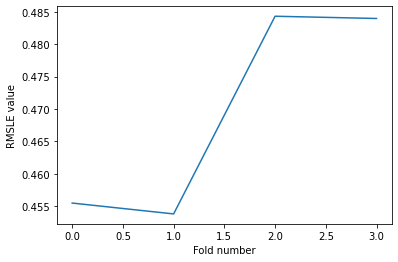

In [32]:
# fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LGBMPipeline(drop_columns=drop_columns[current_family], lags=lags, 
                                                   split_key='family', target_col='sales',
                                                   params=best_cv_params_with_rolling[current_family], 
                                                   rolling_days=rolling_days, rolling_aggr=rolling_aggr)
#     if 'store_nbr' in drop_columns[current_family]:
#         base_pipelines[current_family].fit_params = {}
            
modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines,
                                           zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise',
                        n_jobs=-1)
print_cv_test_scores(scores)

In [ ]:
# train_indices = next(splitter.split(X, y))[0]
# X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]

# for current_family in X_train['family'].unique():
#     print(current_family)
#     X_current_family = X_train[X_train['family'] == current_family].drop(columns=['date', 'family', 'sales'])
#     y_current_family = y_train.loc[X_current_family.index]
    
#     model = lgb.LGBMRegressor()    
#     model.fit(X_current_family, y_current_family)
#     explainer = shap.TreeExplainer(model, X_current_family)
#     shap_values = explainer(X_current_family)
#     shap.plots.bar(shap_values, max_display=25)
    
#     print('\n\n')